# Introduction to a simple Generative Adversarial Network

## Prerequisites

### Knowledge
- https://towardsdatascience.com/must-read-papers-on-gans-b665bbae3317
- https://github.com/soumith/ganhacks
- https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b
- https://skymind.ai/wiki/generative-adversarial-network-gan
- https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
- https://medium.com/@jonathan_hui/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09
- https://en.wikipedia.org/wiki/Generative_adversarial_network
- https://towardsdatascience.com/leonardo-and-the-gan-dream-f69e8553e0af
- https://arxiv.org/abs/1406.2661
- https://github.com/eriklindernoren/Keras-GAN
- https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

import tensorflow_datasets as tfds

### Data

In [2]:
batch_size = 100

# Load the dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

# Labels for real and fake examples
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

print(X_train.shape, np.min(X_train), np.max(X_train))

(60000, 28, 28, 1) -1.0 1.0


## Simple GAN for MNIST 

### Generator

In [3]:
def generator(): 
    model = tf.keras.Sequential([tf.keras.layers.Dense(128),
                                 tf.keras.layers.LeakyReLU(alpha=0.01),
                                 tf.keras.layers.Dense(28*28*1, activation='tanh'),
                                 tf.keras.layers.Reshape([28, 28, 1])])
    return model

generator = generator()

### Discriminator

In [4]:
def discriminator():
    model = tf.keras.Sequential([tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128),
                                 tf.keras.layers.LeakyReLU(alpha=0.01),
                                 tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

discriminator = discriminator()

### Training

In [5]:
generator_opt = tf.keras.optimizers.Adam()
discriminator_opt = tf.keras.optimizers.Adam()

When training the generator, you use

In [6]:
@tf.function
def train_generator(z_sample, label):
    with tf.GradientTape() as tape:
        image = generator(z_sample)
        prediction = discriminator(image)
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true=label, y_pred=prediction))
        # gradient descent and only update generator
        gradients = tape.gradient(loss, generator.trainable_variables)
        generator_opt.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

In [7]:
@tf.function
def train_discriminator(image, label):
    with tf.GradientTape() as tape:
        # calculate loss
        prediction = discriminator(image)
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true=label, y_pred=prediction))
        accuracy = tf.reduce_mean(tf.keras.metrics.binary_accuracy(y_true=label, y_pred=prediction))

        # gradient descent and only update discriminator
        gradient = tape.gradient(loss, discriminator.trainable_variables)
        discriminator_opt.apply_gradients(zip(gradient, discriminator.trainable_variables))
    return loss, accuracy

Iteration 0 d_loss 1.2878325235182804 g_loss tf.Tensor(1.0805156315627304, shape=(), dtype=float64) accuracy 0.46000000834465027


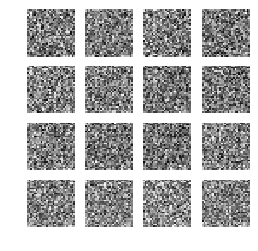

Iteration 2000 d_loss 0.054836410450017865 g_loss tf.Tensor(4.932033073459328, shape=(), dtype=float64) accuracy 0.9850000143051147


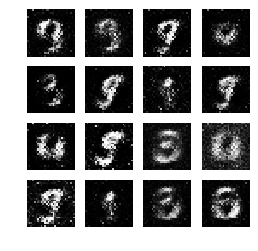

Iteration 4000 d_loss 0.10147381264391221 g_loss tf.Tensor(4.495965620892745, shape=(), dtype=float64) accuracy 0.9800000190734863


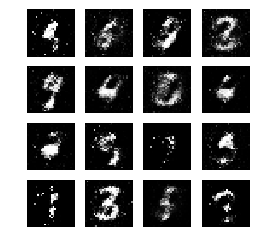

Iteration 6000 d_loss 0.23131208675039144 g_loss tf.Tensor(4.267148091019851, shape=(), dtype=float64) accuracy 0.9049999713897705


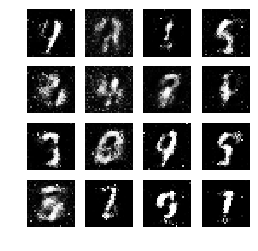

Iteration 8000 d_loss 0.38966436514747343 g_loss tf.Tensor(3.042537764359639, shape=(), dtype=float64) accuracy 0.8149999976158142


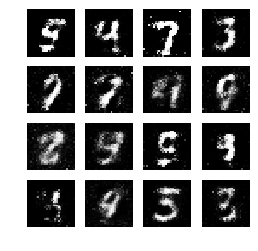

In [8]:
# init lists for losses and accuracies
d_losses, d_accuracies, g_losses = [], [], []

# defining the z dimension
z_dim = 100

ITERATIONS = 10000
for i in range(ITERATIONS):
    # pick a random sample from the datas
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    image = X_train[idx]
    
    # Generate a batch of fake images
    z_sample = np.random.normal(0, 1, (batch_size, z_dim))
    gen_image = generator(z_sample)

    # Discriminator loss and train discriminator on fake and real images
    d_loss_real, d_accuracy_real = train_discriminator(image, real)
    d_loss_fake, d_accuracy_fake = train_discriminator(gen_image, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_accuracy = 0.5 * np.add(d_accuracy_real, d_accuracy_fake)

    # Generator loss
    g_loss = train_generator(z_sample, real)

    # visualization
    if i % 2000 == 0:
        print("Iteration", i, "d_loss", d_loss, "g_loss", g_loss, "accuracy", d_accuracy)
        image_grid_rows=4
        image_grid_columns=4

        # Sample random noise
        z_sample = np.random.normal(0, 1, 
                  (image_grid_rows * image_grid_columns, z_dim))

        # Generate images from random noise 
        gen_imgs = generator(z_sample)
        # Rescale images to 0-1
        gen_imgs = 0.5 * gen_imgs + 0.5

        # Set image grid
        fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                        figsize=(image_grid_rows,image_grid_columns), sharey=True, sharex=True)
        cnt = 0
        for i in range(image_grid_rows):
            for j in range(image_grid_columns):
                # Output image grid
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        
        d_losses.append(d_loss)
        d_accuracies.append(d_accuracy)
        g_losses.append(g_loss)

### Visualization

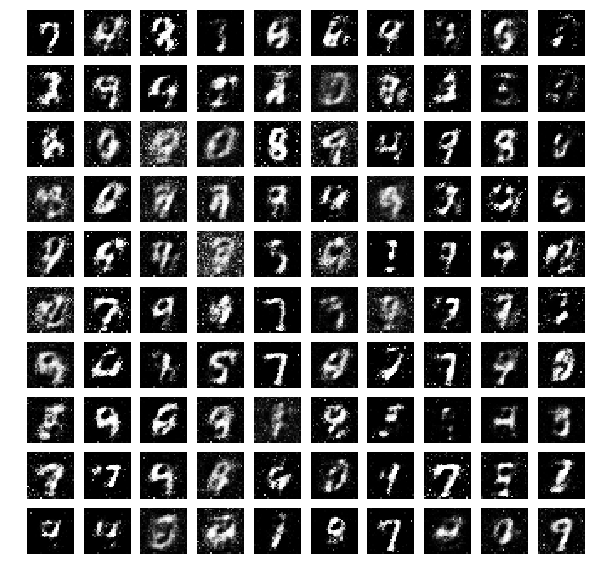

In [9]:
image_grid_rows=10
image_grid_columns=10

# Sample random noise
z_sample = np.random.normal(0, 1, 
          (image_grid_rows * image_grid_columns, z_dim))

# Generate images from random noise 
gen_imgs = generator(z_sample)
# Rescale images to 0-1
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                figsize=(10,10), sharey=True, sharex=True)
cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output image grid
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1

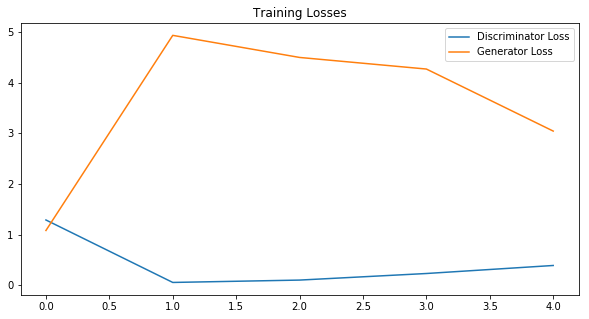

In [10]:
# Plot training losses for Discriminator and Generator
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.figure(figsize=(10,5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("Training Losses")
plt.legend()

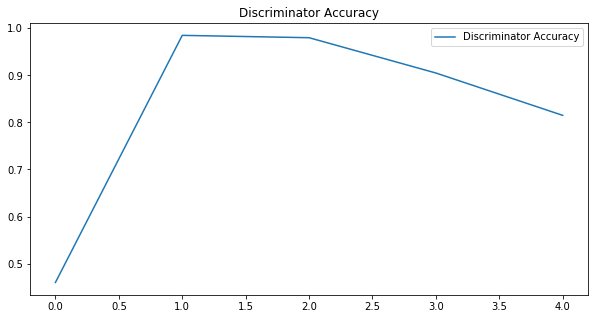

In [11]:
accuracies = np.array(d_accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(10,5))
plt.plot(accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy")
plt.legend()